In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from glob import glob
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import xarray as xr
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cyg import *

In [ ]:
# colormap
cmap = ListedColormap(["#8c510a","#d8b365","#f6e8c3","#c7eae5","#5ab4ac","#01665e"]) # to give colour gradation

#### Loading the CYGNSS data

In [3]:
all_days = []
peak_pow = []
pow_r = []
gr = []
pgt = []
ts = []
sr = []
lat = []
lon = []
SNR = []
inc = []

for files in glob("C:/Users/AJIN RUFUS/OneDrive - IIT Kanpur/CYGNSS_data/*.nc4", recursive=False):
    data = nc.Dataset(files, "r") # to read the netCDF files
    time = data.variables["ddm_timestamp_utc"] # time
    all_days.append(time.units[14:24]) # to get the time stamp of the dataset
    gr.append(data["sp_rx_gain"][:].filled(np.nan)) # receiver antenna gain
    pgt.append(data["gps_eirp"][:].filled(np.nan)) # product of power of the transmitter antenna and transmitter antenna gain 
    sr.append(data["rx_to_sp_range"][:].filled(np.nan)) # range between the surface and receiver
    ts.append(data["tx_to_sp_range"][:].filled(np.nan)) # range between the transmitter and the surface
    SNR.append(data["ddm_snr"][:].filled(np.nan)) # signal to noise ratio
    inc.append(data["sp_inc_angle"][:].filled(np.nan)) # incident angle from the point on the surface
    
    lat.append(data["sp_lat"][:].filled(np.nan)) # latitude of the signal surface 
    lon.append(data["sp_lon"][:].filled(np.nan)) # longitude of hte signal surface
    
    pp = data["power_analog"][:].filled(np.nan) # power analog
    for i in range(len(pp)): # the peak power is the taken as effective power in the bistatic radar equation
        aa = np.max(pp[i][0]), np.max(pp[i][1]), np.max(pp[i][2]), np.max(pp[i][3])
        pow_r.append(aa)
    peak_pow.append(pow_r)
    pow_r = []

#### Computing the Surface reflectivity

In [4]:
# SR = surf_ref(ts,sr,pgt, peak_pow, gr) # surface reflectivity using the bistatic radar equation

SR = surf_ref(ts,sr,pgt, peak_pow, gr)

C:\Users\AJIN RUFUS\Desktop\cyg.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_list1 = np.multiply(t_dist,t_dist) # square of total distance
C:\Users\AJIN RUFUS\Desktop\cyg.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mul_val = [[[1/n for n in num] for num in sublist] for sublist in np.multiply(pgt,gr)]
C:\Users\AJIN RUFUS\Desktop\cyg.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

In [5]:
lon_180 = lon_lon_conv(lon) # conversion of 0 to 360 longitude to -180 to 180 degrees longitude

#### Loading the SMAP data

In [6]:
list_of_paths = glob("C:/Users/AJIN RUFUS/Documents/My Files/CE670a/CE670a Project/SMAP_data/SPL3SMP.008_36.032km_aid0001.nc")

data = nc.Dataset(list_of_paths[0],"r") # reading the data
july_SM = data.variables["Soil_Moisture_Retrieval_Data_AM_soil_moisture"][:] # SMAP soil moisture
july_lat = data.variables["lat"][:] # latitude
july_lon = data.variables["lon"][:] # longitude

In [7]:
XX , YY = np.meshgrid(july_lon,july_lat) # creating a grid of SMAP coordinates

In [8]:
data1 = data_pd(lat, lon_180, SR, gr, inc, SNR, 2902, all_days) # to get the data in pandas dataframe

In [9]:
ref11, date, sn = dt_otl_grid(data1,  2902, XX, YY, SNR = True) # to get the gridded dat of surface reflectivity and SNR during their respective dates

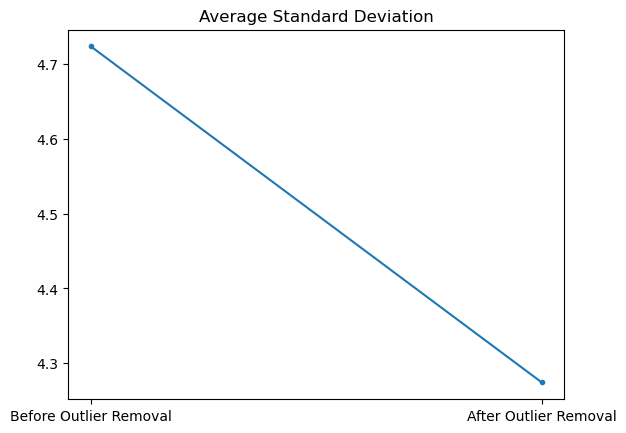

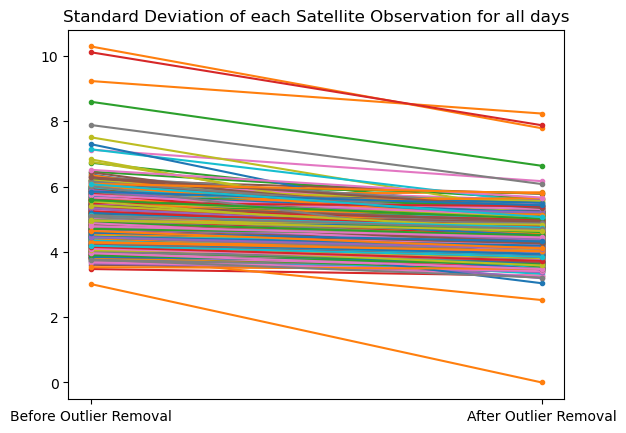

In [10]:
st_change = st_dev_change(data1, 2902, True, True) # to compute the change in standard deviation before and after calibrating

In [11]:
soil_m = [] # reorienting SMAP soil moisture
for i in range(366):
    soil_m.append(np.ma.filled(july_SM[i], np.nan).reshape(-1))

C:\Users\AJIN RUFUS\Desktop\cyg.py:228: RuntimeWarning: Mean of empty slice
  si = np.nanmean(s_data[j:j+days[i]],axis=0)


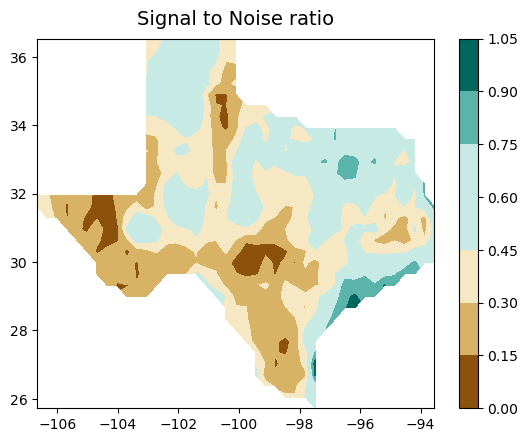

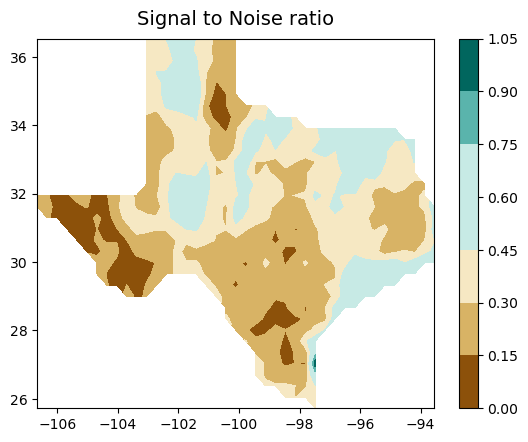

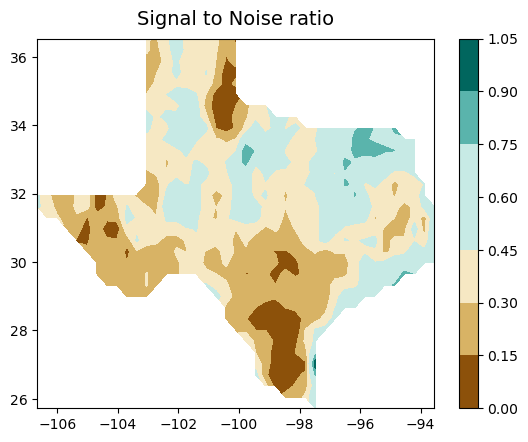

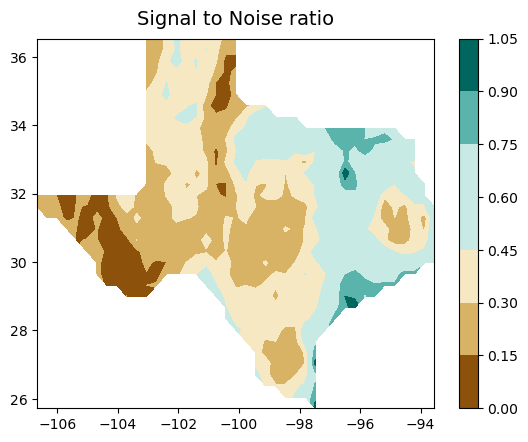

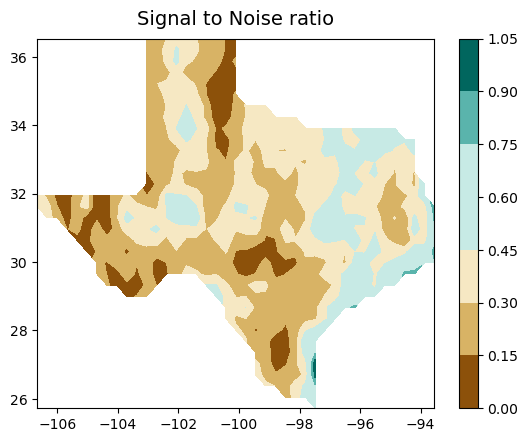

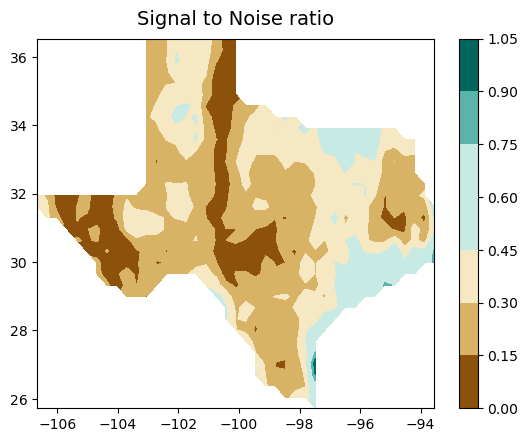

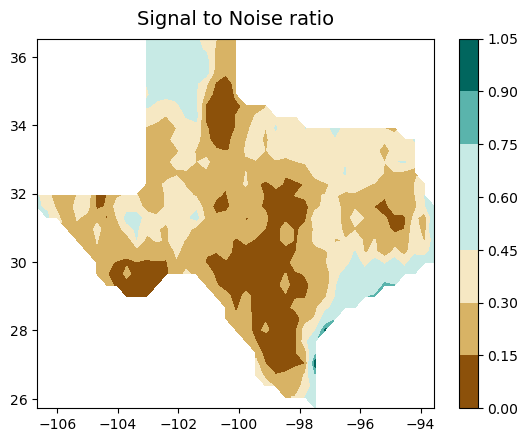

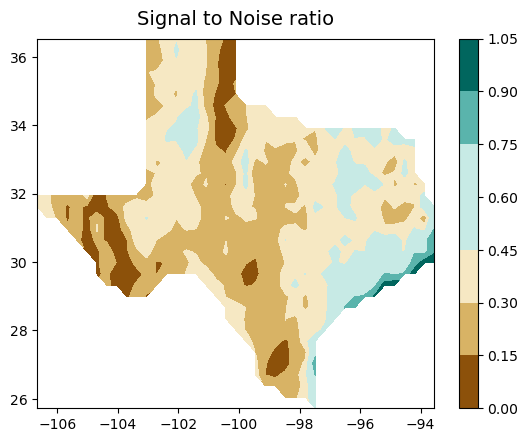

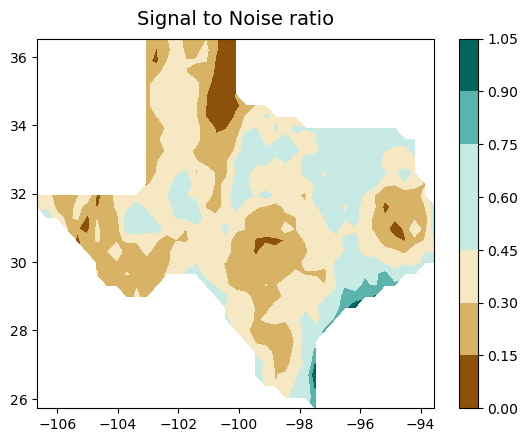

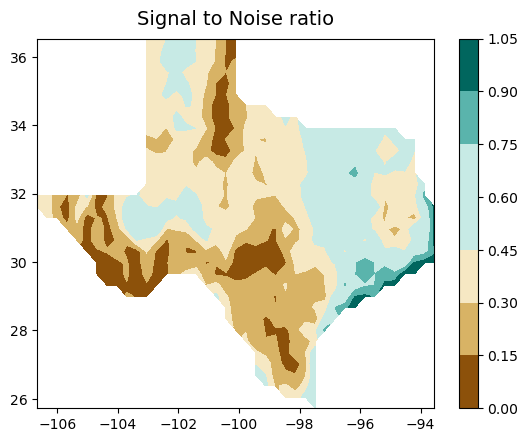

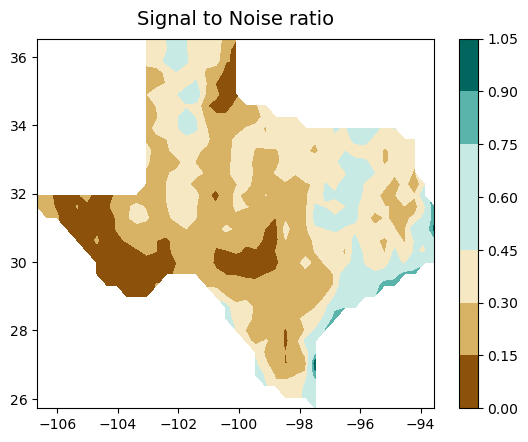

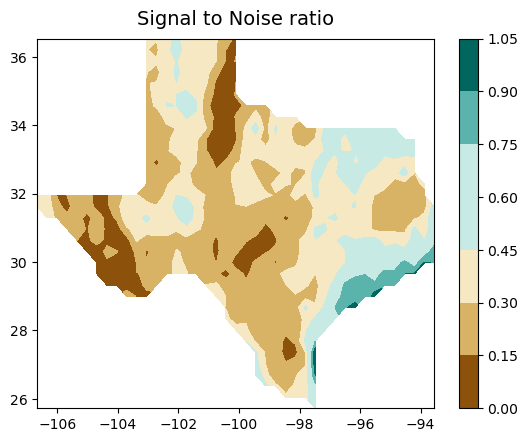

In [12]:
day = [31,29,31,30,31,30,31,31,30,31,30,31]

# monthly mean of signal to noisr ratio 
ab1 = time_agg(day, sn, XX, YY, cmap, typ = "n_shp", plot = True, lat_shape = 34, lon_shape = 41, Title = "Signal to Noise ratio", s_data = soil_m)

In [13]:
date1 = data_date(date) # to get one date value for a day

In [14]:
final = pd.DataFrame({"reflectivity": ref11,"Date":date1, "SNR":sn}) # average of the gridded data
final1 = final.sort_values(by = "Date") # to sort the values according to date
final3 = final1.reset_index(drop=True) # to reset the reoriented points

In [15]:
# convert the 'Date' column to a datetime object
final3['Date'] = pd.to_datetime(final3['Date'])

mean_df = final3.groupby('Date')["reflectivity"]

mean_df1 = final3.groupby('Date')["SNR"]

mean_values = mean_df.apply(lambda x: np.mean(x)) # to get the mean values of surface reflectivity

mean_values_snr = mean_df1.apply(lambda x: np.mean(x)) # to get the mean values of SNR

In [16]:
unique_days = final3["Date"].unique() # to ge the unique date values, that is to avoid repetition

In [17]:
jpg = []
sr1 = []
so = []
soil = []

 # combine all the day values for each point
for i in range(1394):
    for j in range(366):
        jpg.append(mean_values[j][i]) # to combine the surface reflectivity values
        so.append(soil_m[j][i]) # to combine the soil moisture values 
    sr1.append(jpg)
    soil.append(so)
    jpg=[]
    so = []

In [18]:
coe = corr_coeff(1394, sr1, soil) # correlation coefficient

C:\Users\AJIN RUFUS\Desktop\cyg.py:202: RuntimeWarning: invalid value encountered in double_scalars
  coeff.append(jj/np.sqrt(hh*gg))


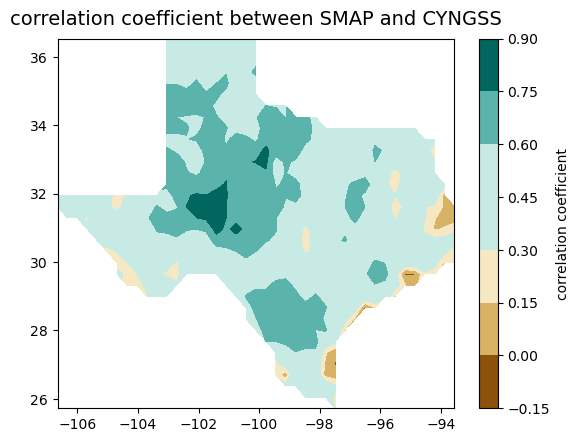

In [19]:
# to plot the points
ax = plt.contourf(XX,YY,np.reshape(coe,(34,41)),cmap = cmap) 
plt.title(f'correlation coefficient between SMAP and CYNGSS', fontsize=14,pad = 10)  
plt.contourf(XX,YY,np.reshape(coe,(34,41)),cmap = cmap) # plotting the sea surface temperature of each month
plt.colorbar(extend='both',label = "correlation coefficient")
plt.show()

In [20]:
max_ind = np.where(np.reshape(coe,(34,41)) == np.nanmax(np.reshape(coe,(34,41)))) # compute the index of maximum value

In [21]:
# coordinates of maximum correlation coefficient
x1 = XX[int(max_ind[0][0])][int(max_ind[1][0])] # longitude
y1 = YY[int(max_ind[0][0])][int(max_ind[1][0])] # latitude

In [22]:
x1,y1

(-101.41535582364148, 31.29294501181829)

####  Linear Regression of the Maximum Correlation Coeffficient Point

In [23]:
ak = pd.DataFrame({"SM":soil[int(np.array(np.where(coe == np.nanmax(coe))))], "SR":sr1[int(np.array(np.where(coe == np.nanmax(coe))))]})

ak1 = ak[~np.isnan(ak["SR"].astype(float))]
ak2 = ak1[~np.isnan(ak1["SM"].astype(float))]
    
ak3 = ak2.reset_index(drop=True)
SM111 = min_max(ak3["SM"])
reflect111 = min_max(ak3["SR"])

adj, m, c = linear_reg(reflect111, SM111) # linear regression of adj is the 

In [24]:
m # slope

0.861570284271427

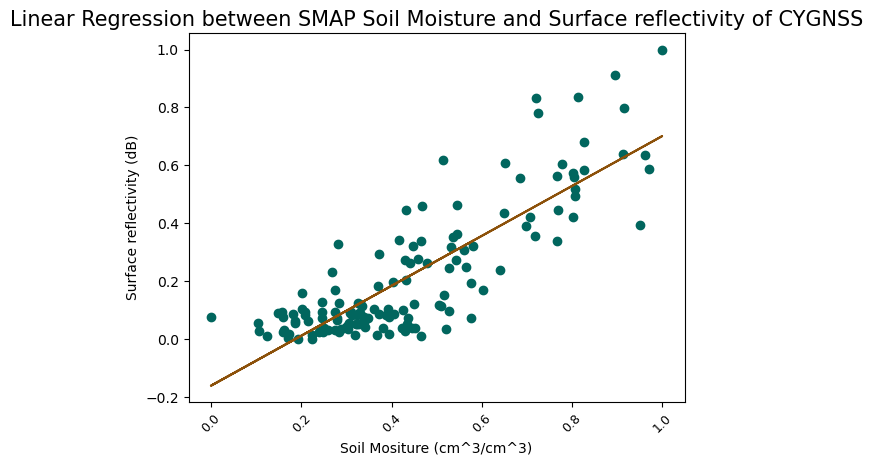

In [25]:
fig,ax = plt.subplots()
ax.plot(reflect111,adj, c ="#8c510a")
ax.scatter(reflect111, SM111, c ="#01665e")
ax.set_title("Linear Regression between SMAP Soil Moisture and Surface reflectivity of CYGNSS", fontsize = 15, pad = 5)
ax.set_xlabel("Soil Mositure (cm^3/cm^3)")
ax.set_ylabel("Surface reflectivity (dB)")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
plt.show()

C:\Users\AJIN RUFUS\Desktop\cyg.py:228: RuntimeWarning: Mean of empty slice
  si = np.nanmean(s_data[j:j+days[i]],axis=0)


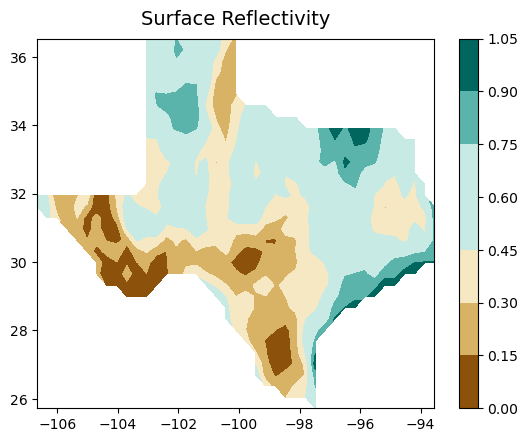

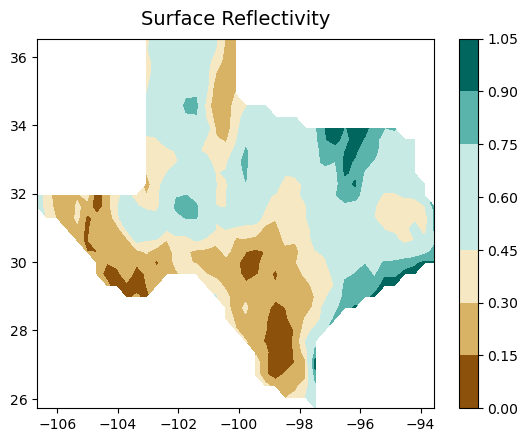

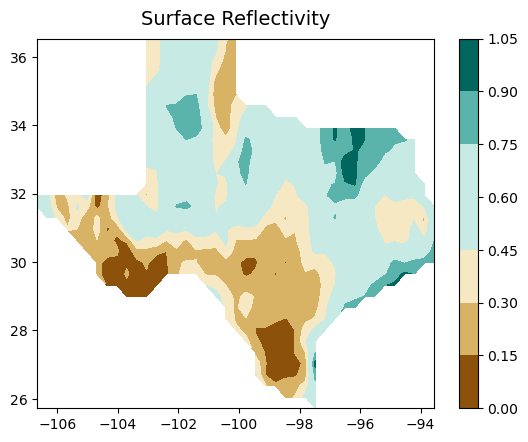

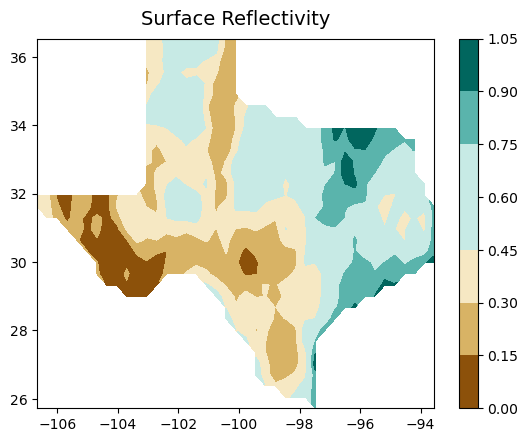

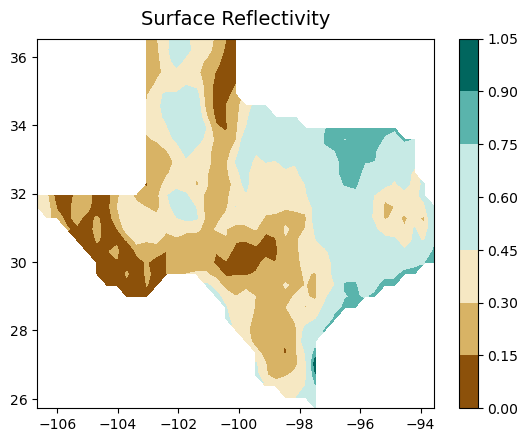

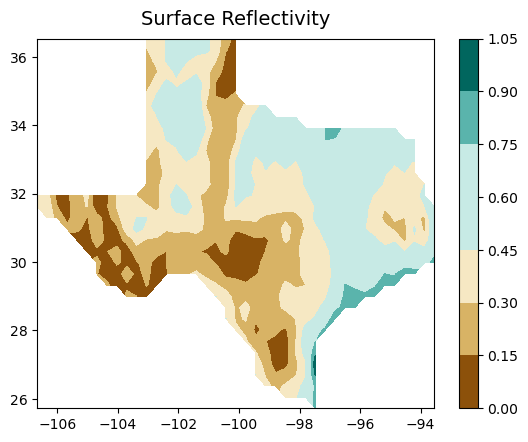

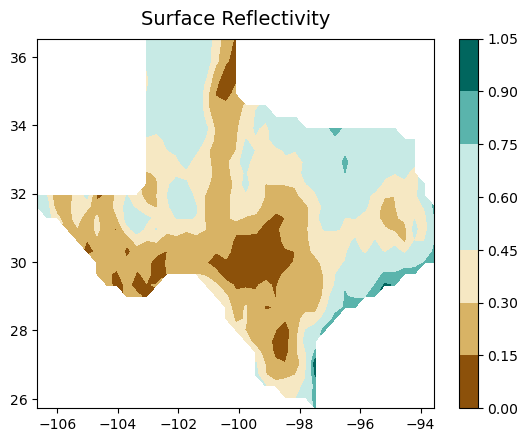

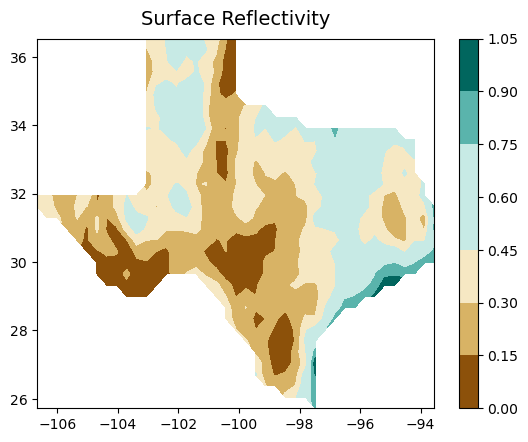

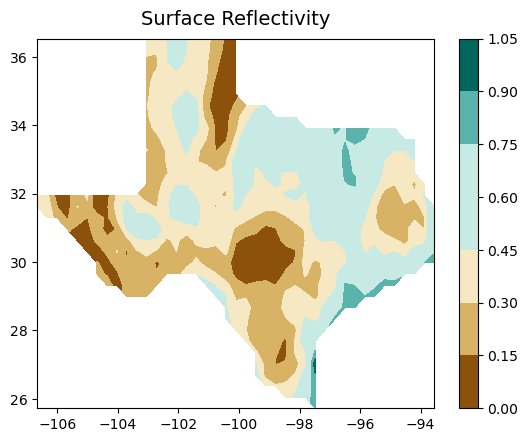

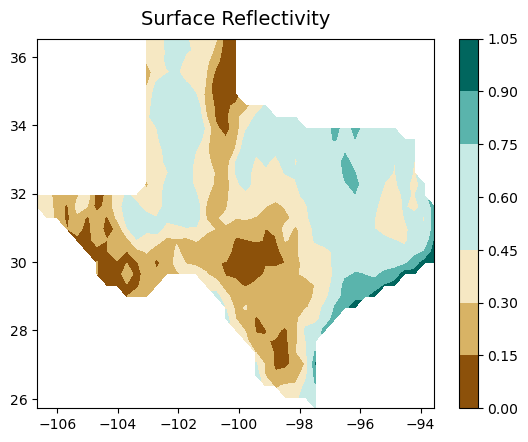

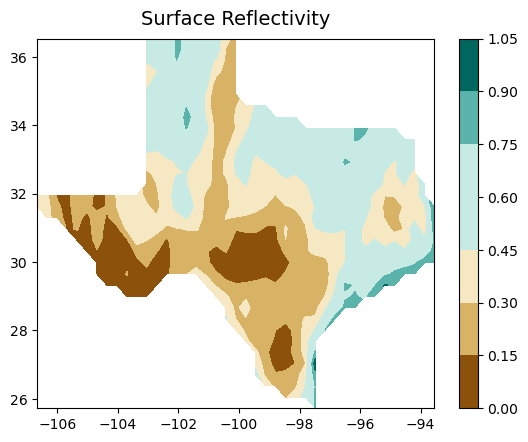

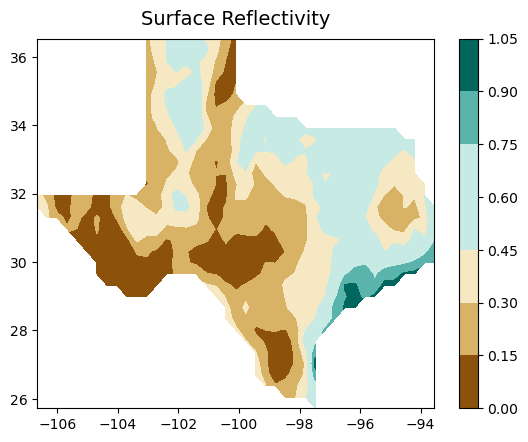

In [26]:
# to get the monthly average value of surface reflectivity
ab1 = time_agg(day, mean_values, XX, YY, cmap, typ = "n_shp", plot = True, lat_shape = 34, lon_shape = 41, Title = "Surface Reflectivity", s_data = soil_m) 

C:\Users\AJIN RUFUS\Desktop\cyg.py:224: RuntimeWarning: Mean of empty slice
  abcd2 = np.nanmean(data[j:j+days[i]],axis=0)


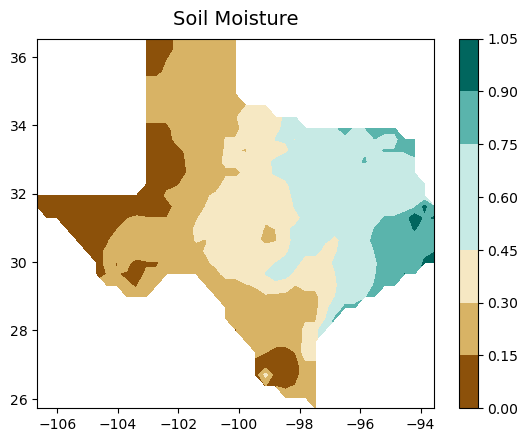

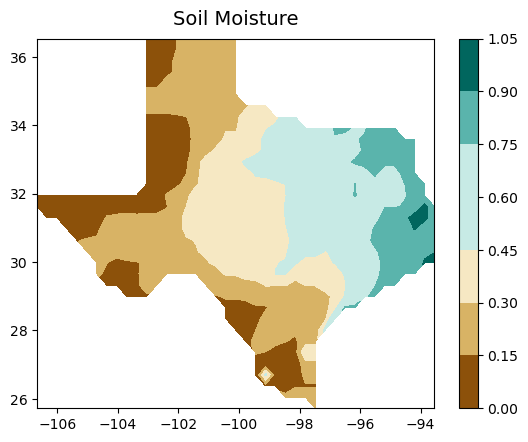

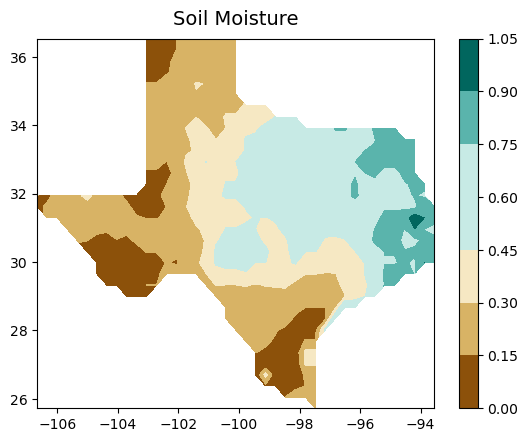

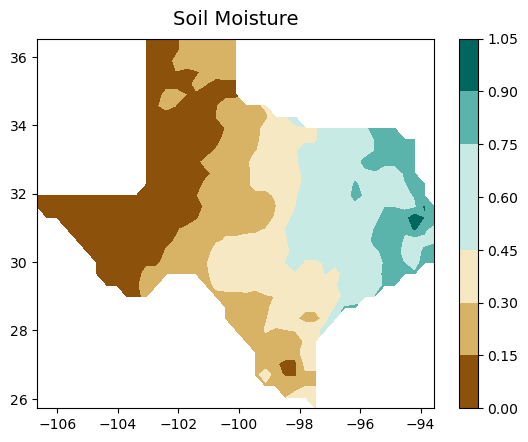

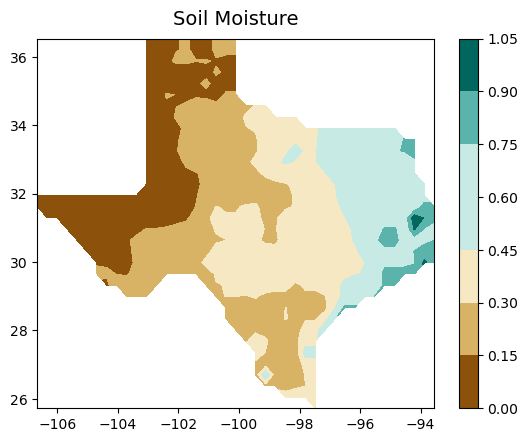

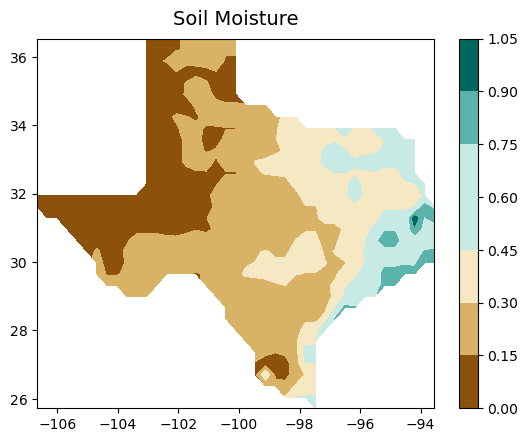

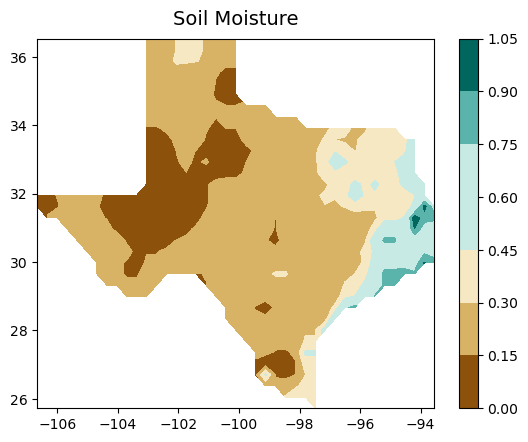

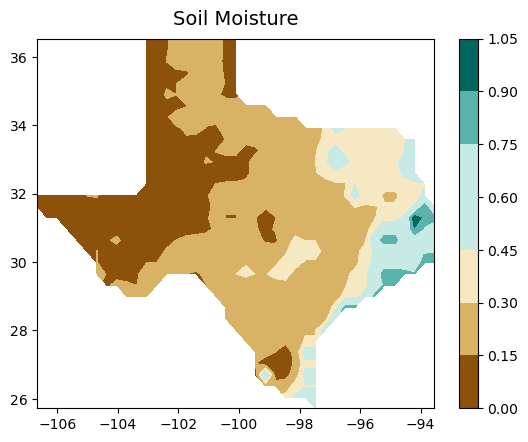

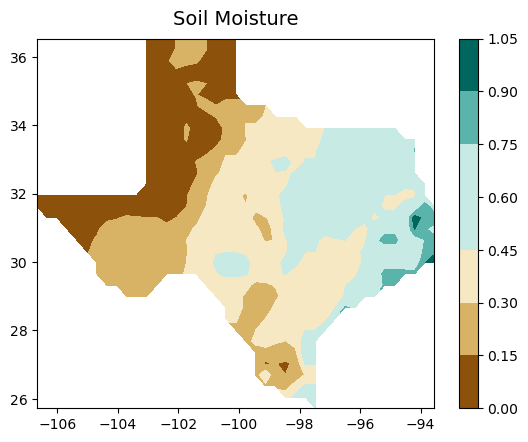

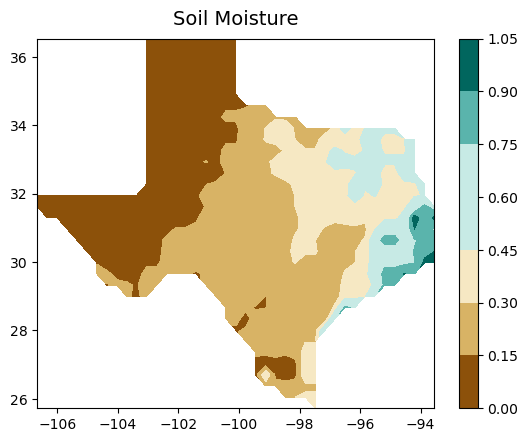

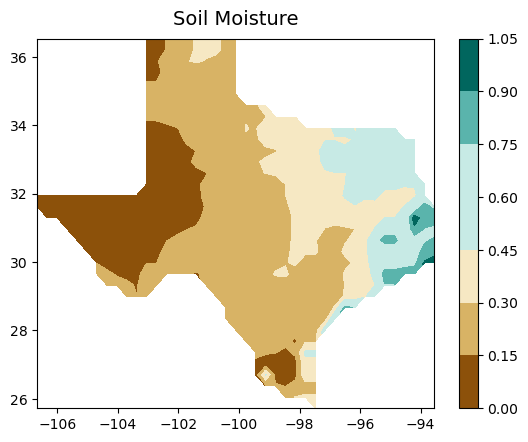

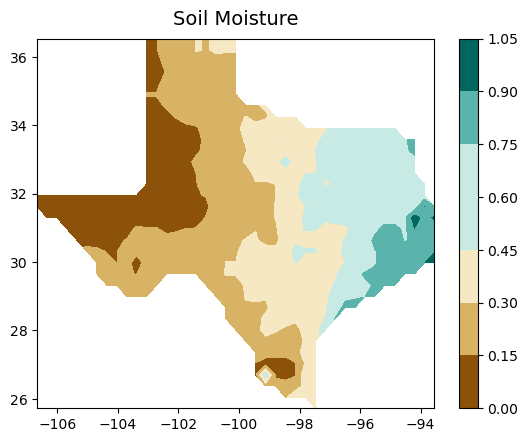

In [27]:
# to get the monthly average value of soil moisture
ab1_b = time_agg(day, soil_m, XX, YY, cmap, typ = "shp", plot = True, lat_shape = 34, lon_shape = 41, Title = "Soil Moisture", s_data = None)

#### Temporal

Text(0, 0.5, 'Surface Reflectivity')

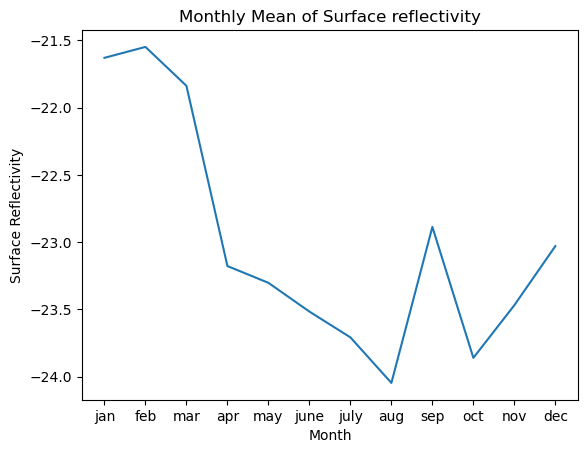

In [28]:
month_name = ["jan","feb","mar","apr","may","june","july","aug","sep","oct","nov","dec"] # month name
plt.plot(month_name, ab1)
plt.title("Monthly Mean of Surface reflectivity") # for cygnss
plt.xlabel("Month")
plt.ylabel("Surface Reflectivity")

Text(0, 0.5, 'Soil Moisture')

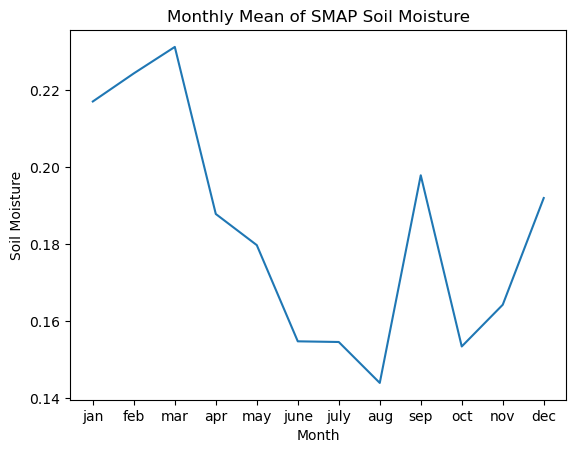

In [29]:
plt.plot(month_name, ab1_b)
plt.title("Monthly Mean of SMAP Soil Moisture") # for SMAP
plt.xlabel("Month")
plt.ylabel("Soil Moisture")

#### Half yearly variation

In [30]:
day = [183,183]

j =0

SS = []
RR = []

for i in range(len(day)):
    abcd2 = np.nanmean(soil_m[j:j+day[i]],axis=0) # to compute the half yearly average 

    SS.append(abcd2) # soil moisture of SMAP
    one  = np.mean(mean_values[j:j+day[i]],axis=0)
    
    abcd1 = one*abcd2/abcd2

    RR.append(abcd1) # surface reflectivity of CYGNSS
    
    j = j+day[i]

C:\Users\AJIN RUFUS\AppData\Local\Temp\ipykernel_12800\1557810462.py:9: RuntimeWarning: Mean of empty slice
  abcd2 = np.nanmean(soil_m[j:j+day[i]],axis=0) # to compute the half yearly average


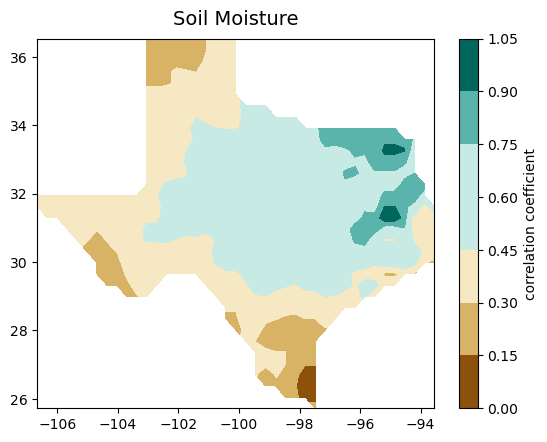

In [31]:
SS1 = SS[0]-SS[1]
RR1 = RR[0]-RR[1]

# normalisation
SS2 = min_max(SS1)
RR2 = min_max(RR1)

ax = plt.contourf(XX,YY,np.reshape(SS2,(34,41)),cmap = cmap) # to plot the half yearly soil moisture variation from SMAP
plt.title(f'Soil Moisture', fontsize=14,pad = 10)  
plt.contourf(XX,YY,np.reshape(SS2,(34,41)),cmap = cmap) 
plt.colorbar(extend='both',label = "correlation coefficient")

#### CYGNSS

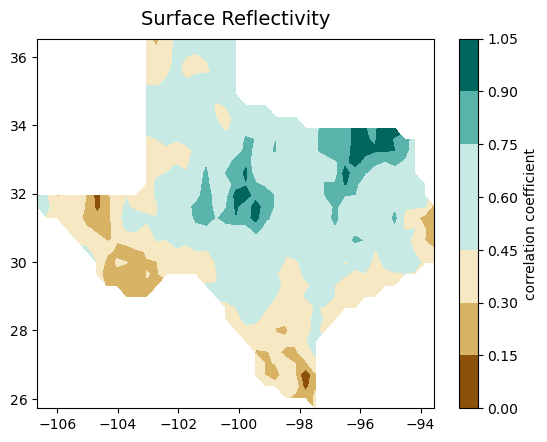

In [32]:
ax = plt.contourf(XX,YY,np.reshape(RR2,(34,41)),cmap = cmap) 
plt.title(f'Surface Reflectivity', fontsize=14,pad = 10)  
plt.contourf(XX,YY,np.reshape(RR2,(34,41)),cmap = cmap) # to plot the half yearly surface reflectivity variation from CYGNSS
plt.colorbar(extend='both',label = "correlation coefficient")

#### Reading ESA data

In [33]:
sm_esa = []
for files in glob("C:/Users/AJIN RUFUS/Documents/My Files/CE670a/CE670a Project/ESA/esacci20/*.nc", recursive=False):
    data = nc.Dataset(files, "r")
    sm_esa.append(data.variables["sm"][:]) # ESA soil moisture
    
lat_esa = data.variables["lat"][:] # latitude
lon_esa = data.variables["lon"][:] # longitude

In [34]:
# x_esa, y_esa = np.meshgrid(lon_esa,lat_esa) 

In [35]:
# sss = []
# for i in sm_esa:
#     sss.append(i[0][:][:].reshape(1,-1)) # reshaping the ESA values

# sm1 = np.nanmean(sss[0:366],axis=0) 

# sm1 = min_max(sm1)

# sm1 = np.reshape(sm1,(720,1440))

C:\Users\AJIN RUFUS\AppData\Local\Temp\ipykernel_12800\2876183165.py:5: RuntimeWarning: Mean of empty slice
  sm1 = np.nanmean(sss[0:366],axis=0)


In [36]:
j = 0

sm1_b = []

day = [31,29,31,30,31,30,31,31,30,31,30,31]

for i in range(len(day)):
    sm1_a = np.nanmean(sm_esa[j:j+day[i]]) # tocompute the monthly mean of ESA values
    
    sm1_b.append(sm1_a)
        
    j = j+day[i]

#### YEARLY MEAN

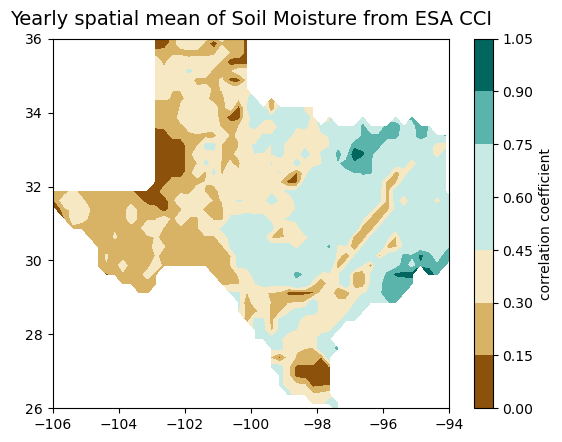

In [37]:
# from matplotlib.colors import ListedColormap

# cmap = ListedColormap(["#8c510a","#d8b365","#f6e8c3","#c7eae5","#5ab4ac","#01665e"]) # to give colour gradation

# ax = plt.contourf(x_esa,y_esa,sm1,cmap = cmap) 
# plt.title(f'Yearly spatial mean of Soil Moisture from ESA CCI', fontsize=14,pad = 10)  
# plt.contourf(x_esa,y_esa,sm1,cmap = cmap) # plotting the sea surface temperature of each month
# plt.xlim(-106, -94)
# plt.ylim(26, 36)
# plt.colorbar(extend='both',label = "correlation coefficient")
# plt.show()

In [38]:
# to get only the values within the Texas region
esa_lat = lat_esa[215:257] # latitude
esa_lon = lon_esa[294:345] # longitude

In [39]:
x_esa, y_esa = np.meshgrid(esa_lon, esa_lat) # gridding of ESA coordinate points

In [40]:
ref11, date, sn = dt_otl_grid(data1,  2902, x_esa, y_esa, SNR = False) # to get the surface reflectivity of CYNGSS with respect to the 0.25 X 0.25 degree grid of ESA 

In [41]:
date1 = data_date(date) # to get one date value for a day

In [42]:
final = pd.DataFrame({"reflectivity": ref11,"Date":date1}) # average of the gridded data

In [43]:
final1 = final.sort_values(by = "Date") # sort the data accroding to the date

final3 = final1.reset_index(drop=True)

In [44]:
# convert the 'Date' column to a datetime object
final3['Date'] = pd.to_datetime(final3['Date'])

# group the DataFrame by date
mean_df = final3.groupby('Date')["reflectivity"]

mean_values = mean_df.apply(lambda x: np.mean(x)) # to get the mean values of surface reflectivity

In [46]:
unique_days = final3["Date"].unique() # to get only one value for a date

In [47]:
esa_sm = []
for i in range(len(sm_esa)):
    esa_sm.append(sm_esa[i][0][215:257,294:345]) # to get the ESA values only within the texas region
    
soil_m_esa = []
for i in range(366):
    soil_m_esa.append(np.ma.filled(esa_sm[i], np.nan).reshape(-1)) # reshapingthe values

In [48]:
jpg = []
jpeg = []
so = []
soil = []

for i in range(2142):
    for j in range(366):
        jpg.append(mean_values[j][i])
        so.append(soil_m_esa[j][i])
    jpeg.append(jpg)
    soil.append(so)
    jpg=[]
    so = []

In [50]:
coe1 = corr_coeff(2142, soil, jpeg) # to compute the correaltio nocefficient between CYGNSS and ESA

C:\Users\AJIN RUFUS\Desktop\cyg.py:202: RuntimeWarning: invalid value encountered in double_scalars
  coeff.append(jj/np.sqrt(hh*gg))


In [51]:
coe1[1373] = np.nan # manually removing a point which has high correlation but has very less values 

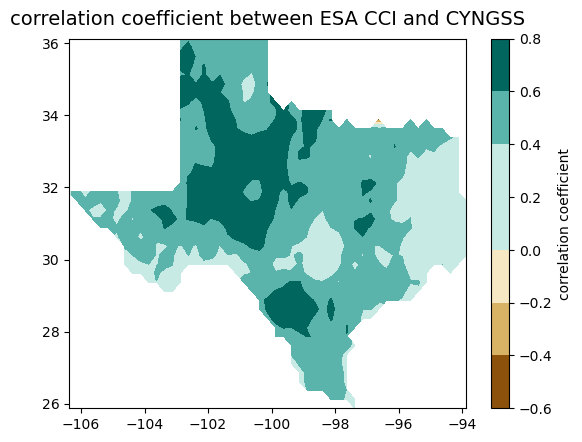

In [52]:
ax = plt.contourf(x_esa,y_esa,np.reshape(coe1,(42,51)),cmap = cmap) 
plt.title(f'correlation coefficient between ESA CCI and CYNGSS', fontsize=14,pad = 10)  
plt.contourf(x_esa,y_esa,np.reshape(coe1,(42,51)),cmap = cmap)
plt.colorbar(extend='both',label = "correlation coefficient")
plt.show()

In [53]:
max_ind = np.where(np.reshape(coe1,(42,51)) == np.nanmax(np.reshape(coe1,(42,51)))) # index of highest correlation coeffcient

In [54]:
x1 = x_esa[int(max_ind[0][0])][int(max_ind[1][0])] # longitude of highest correaltion coefficient
y1 = y_esa[int(max_ind[0][0])][int(max_ind[1][0])] # latitude of highest correaltion coefficient
y1, x1

(33.125, -99.875)

### Linear Regression for the point of maximum correlation

In [55]:
ak = pd.DataFrame({"SM":soil[int(np.array(np.where(coe1 == np.nanmax(coe1))))], "SR":jpeg[int(np.array(np.where(coe1 == np.nanmax(coe1))))]})

ak1 = ak[~np.isnan(ak["SR"].astype(float))]
ak2 = ak1[~np.isnan(ak1["SM"].astype(float))]
    
ak3 = ak2.reset_index(drop=True)

# normalised

first111 = np.max(ak3["SR"])
first1111 = np.min(ak3["SR"])
second222 = np.max(ak3["SM"])
second2222 = np.min(ak3["SM"])
    
reflect111 = (ak3["SR"] - first1111)/(first111-first1111)
SM111 = (ak3["SM"] - second2222)/(second222-second2222)

adj, m, c = linear_reg(reflect111, SM111)

In [56]:
m # slope value

0.9996316598259742

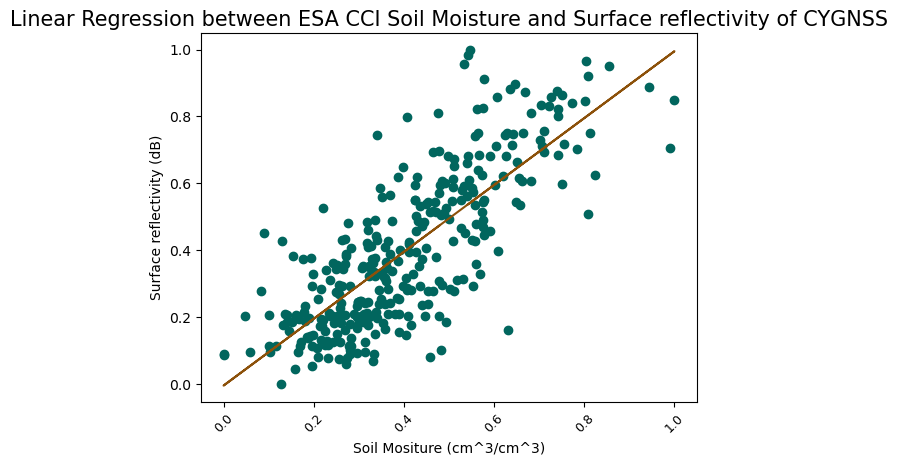

In [57]:
fig,ax = plt.subplots()
ax.plot(reflect111,adj, c ="#8c510a")
ax.scatter(reflect111, SM111, c ="#01665e")
ax.set_title("Linear Regression between ESA CCI Soil Moisture and Surface reflectivity of CYGNSS", fontsize = 15, pad = 5)
ax.set_xlabel("Soil Mositure (cm^3/cm^3)")
ax.set_ylabel("Surface reflectivity (dB)")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
plt.show()

C:\Users\AJIN RUFUS\Desktop\cyg.py:228: RuntimeWarning: Mean of empty slice
  si = np.nanmean(s_data[j:j+days[i]],axis=0)


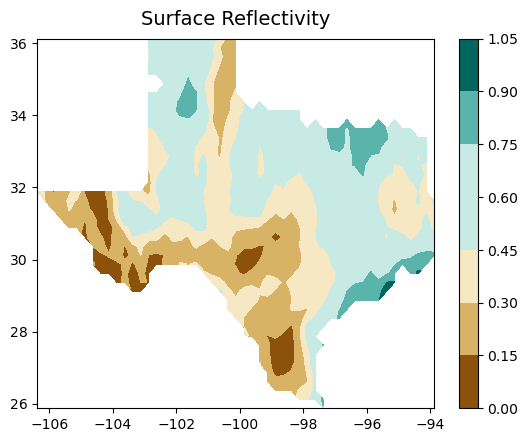

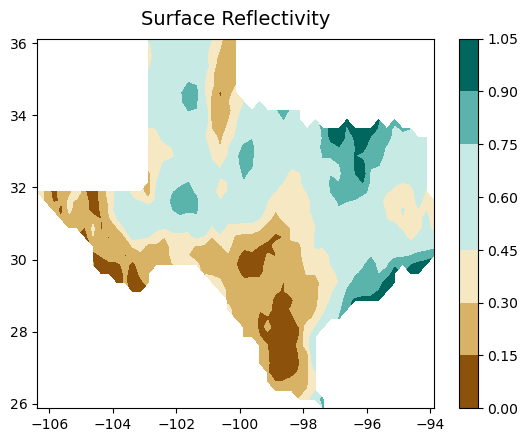

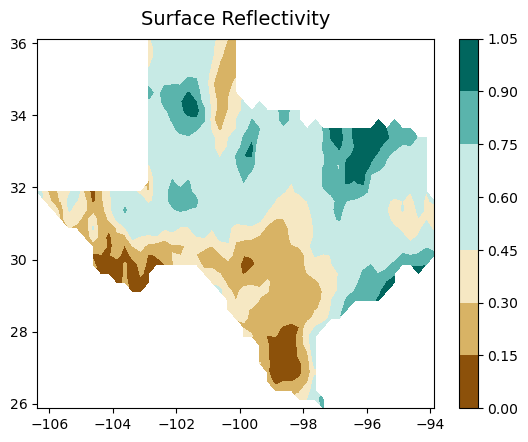

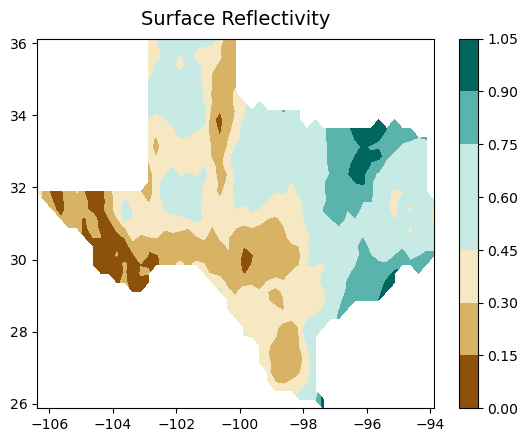

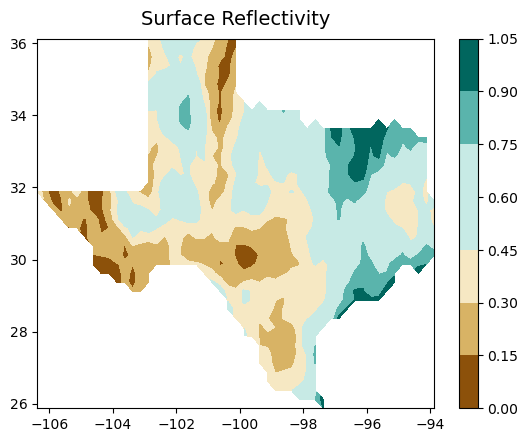

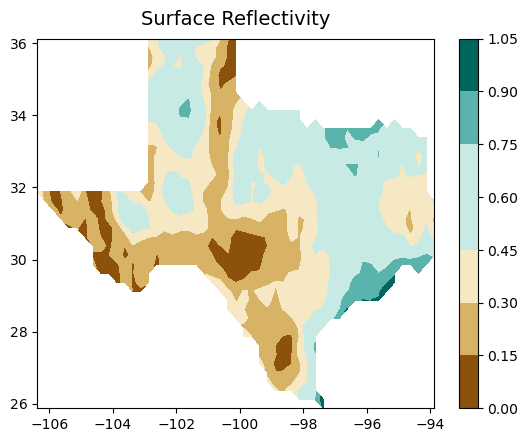

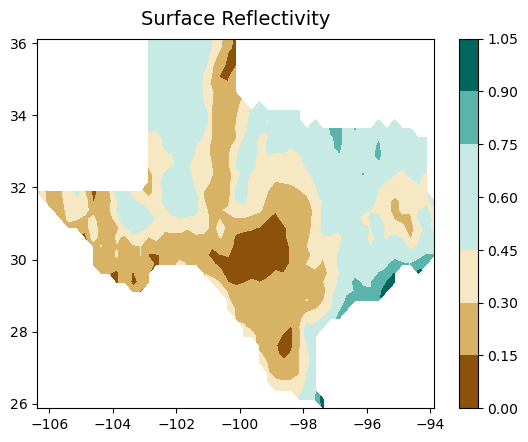

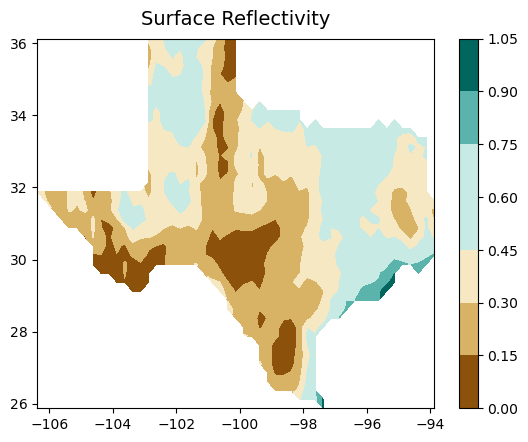

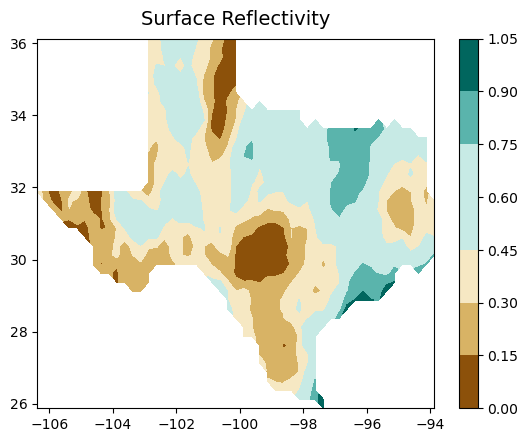

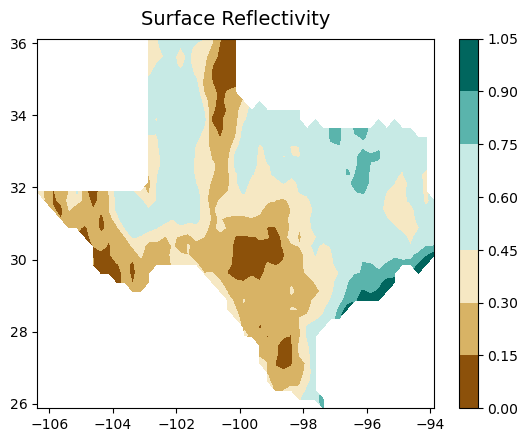

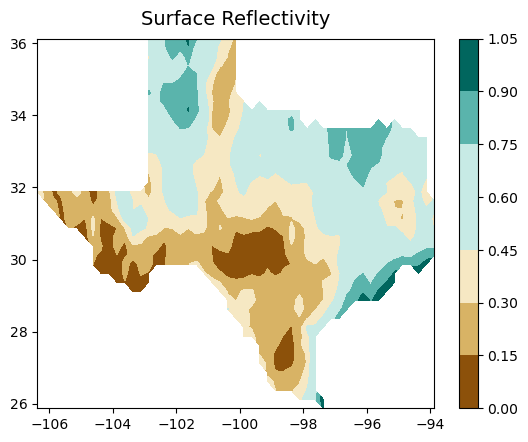

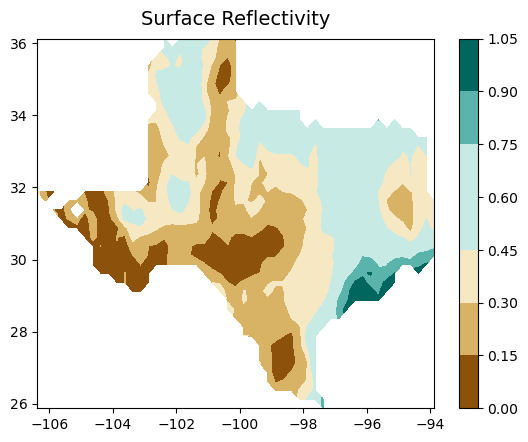

In [58]:
day = [31,29,31,30,31,30,31,31,30,31,30,31] # montlhy mean of CYNGSS surface reflectivity with respect to the ESA grid size

ab1 = time_agg(day, mean_values, x_esa, y_esa, cmap, typ = "n_shp", plot = True, lat_shape = 42, lon_shape = 51, Title = "Surface Reflectivity", s_data = soil_m_esa)

### Temporal mean of Surface reflectivity

In [59]:
norm1 = np.nanmax(ab1) # normalising
norm2 = np.nanmin(ab1)
norm3 = (ab1 - norm2)/(norm1-norm2)

Text(0, 0.5, 'Soil Moisture')

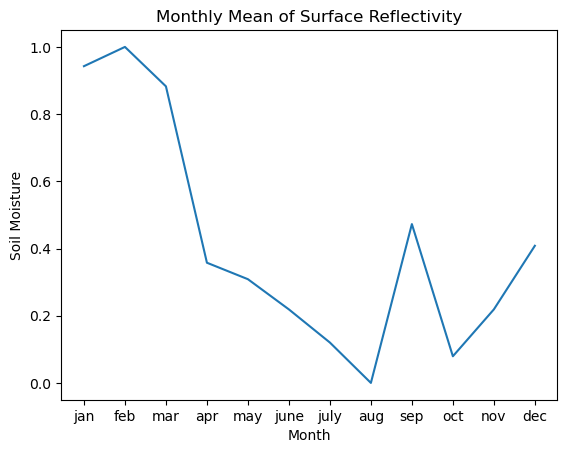

In [60]:
plt.plot(month_name, norm3)
plt.title("Monthly Mean of Surface Reflectivity")
plt.xlabel("Month")
plt.ylabel("Soil Moisture")

C:\Users\AJIN RUFUS\Desktop\cyg.py:224: RuntimeWarning: Mean of empty slice
  abcd2 = np.nanmean(data[j:j+days[i]],axis=0)


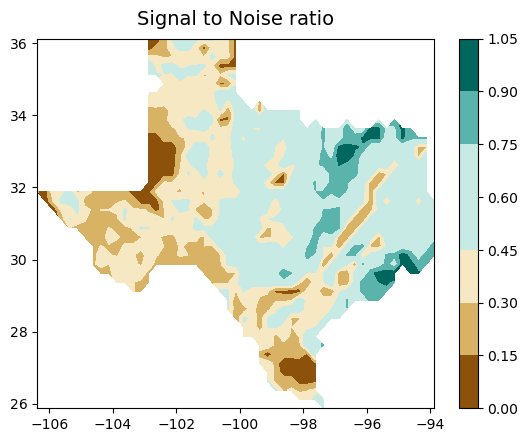

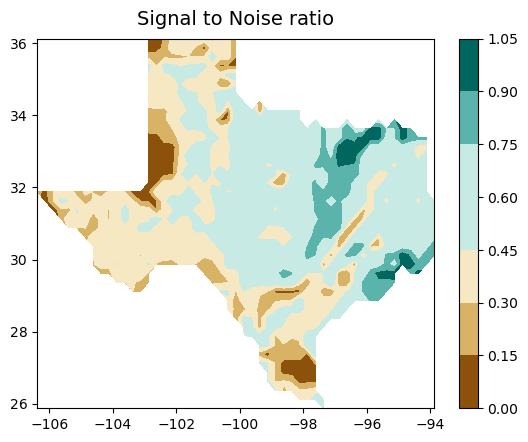

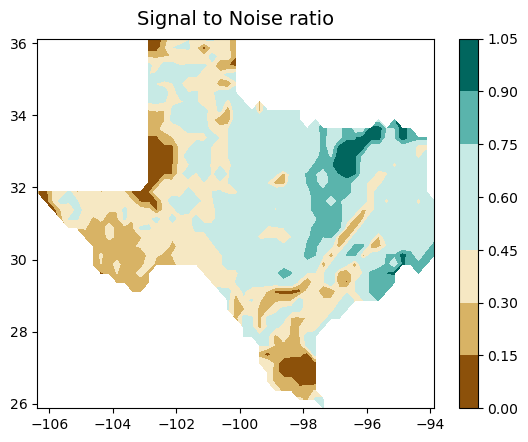

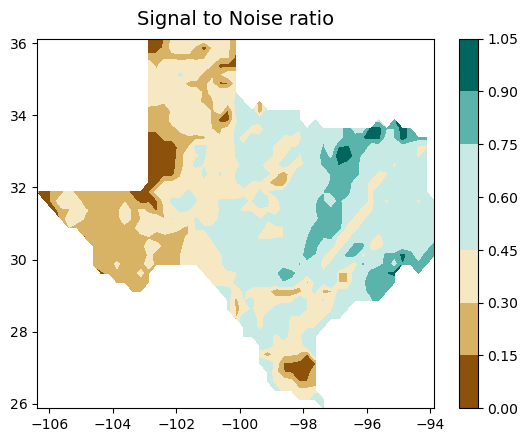

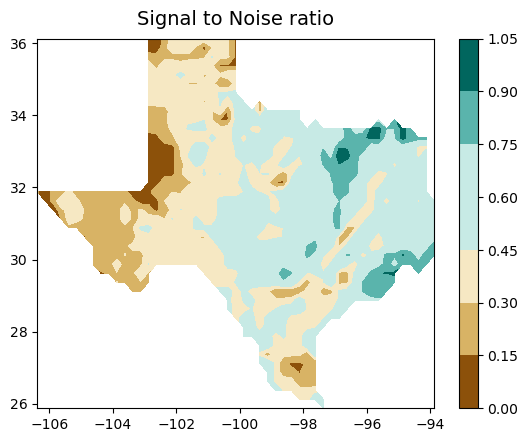

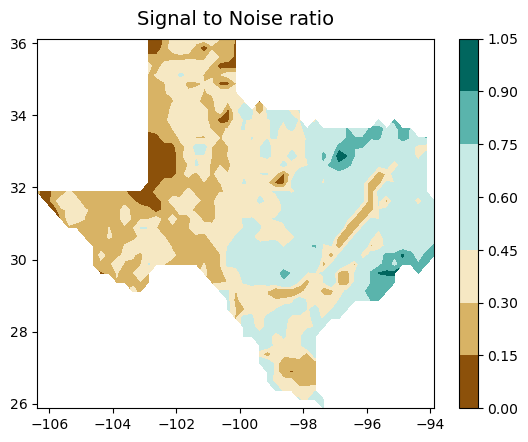

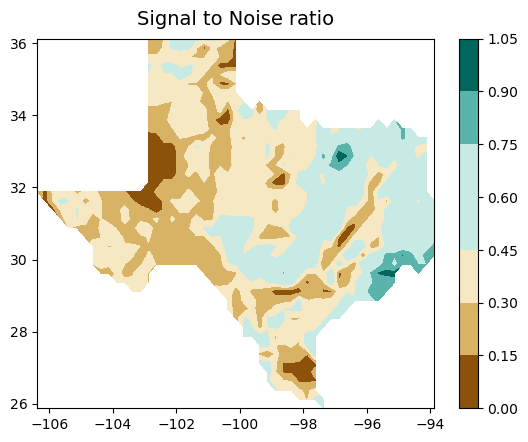

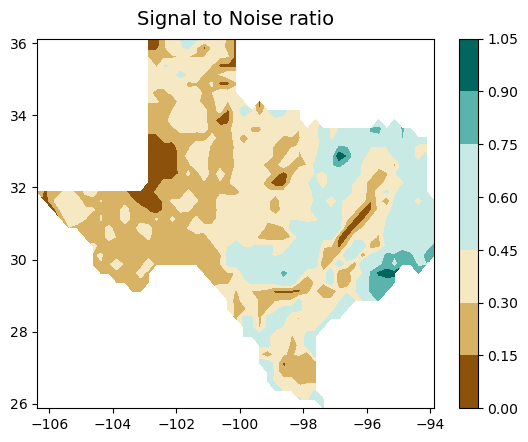

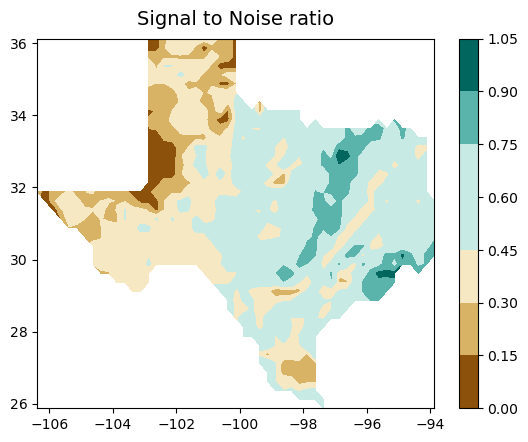

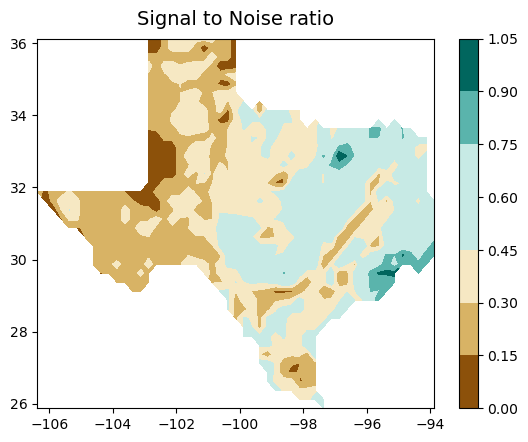

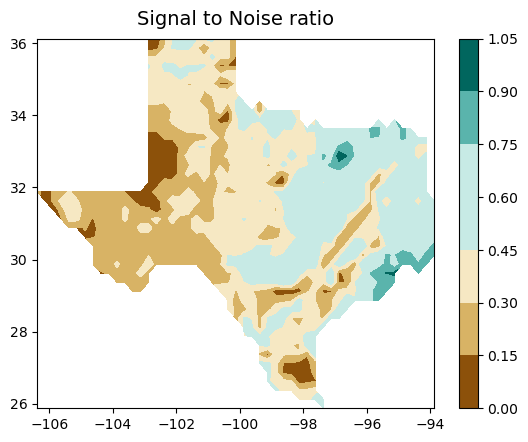

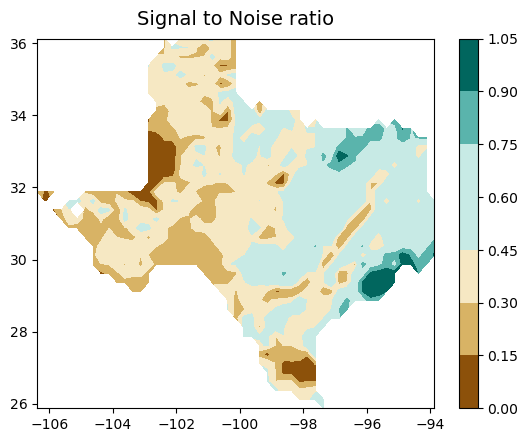

In [62]:
# to compute the monthly mean of ESA soil moisture
ab1_b = time_agg(day, soil_m_esa, x_esa, y_esa, cmap, typ = "shp", plot = True, lat_shape = 42, lon_shape = 51, Title = "Monthly mean of ESA soil Moisture", s_data = None)

In [63]:
norm1 = np.nanmax(ab1_b) # nomalising hte mean of soil moisture from ESA
norm2 = np.nanmin(ab1_b)
norm3 = (ab1_b - norm2)/(norm1-norm2)

Text(0, 0.5, 'Soil Moisture')

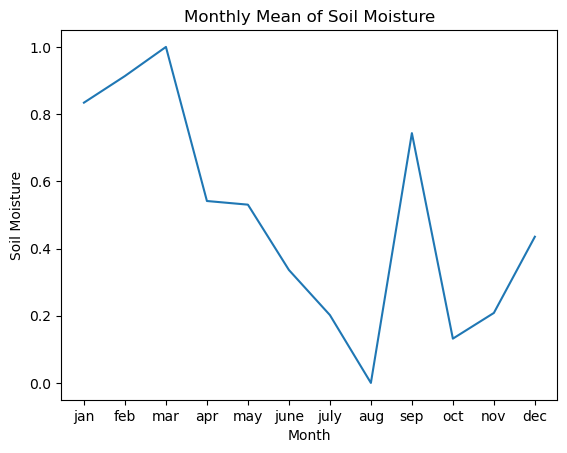

In [64]:
plt.plot(month_name, norm3)
plt.title("Monthly Mean of Soil Moisture") # temporal mean of ESA soil moisture
plt.xlabel("Month")
plt.ylabel("Soil Moisture")

### Half yearly variation

In [66]:
day = [183,183]

j =0

SS = []
RR = []

for i in range(len(day)):
    abcd2 = np.nanmean(soil_m_esa[j:j+day[i]],axis=0)

    SS.append(abcd2) # half yearly variation of ESA soil moisture
    one  = np.mean(mean_values[j:j+day[i]],axis=0)
    
    abcd1 = one*abcd2/abcd2

    RR.append(abcd1) # half yearly variation of CYNGSS soil moisture
    
    j = j+day[i]

C:\Users\AJIN RUFUS\AppData\Local\Temp\ipykernel_12800\1083106475.py:9: RuntimeWarning: Mean of empty slice
  abcd2 = np.nanmean(soil_m_esa[j:j+day[i]],axis=0)


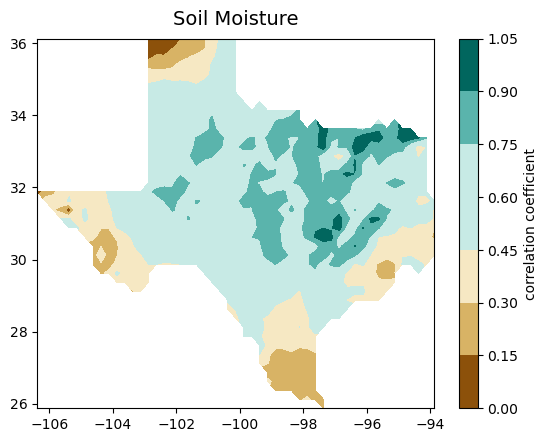

In [67]:
SS1 = SS[0]-SS[1] # first six months minus last six months of ESA soil moisture

RR1 = RR[0]-RR[1] # first six months minus last six months of CYGNSS surface reflectivity

first111 = np.nanmax(SS1) # normalising
first1111 = np.nanmin(SS1)
second222 = np.nanmax(RR1)
second2222 = np.nanmin(RR1)

SS2 = (SS1 - first1111)/(first111-first1111)
RR2 = (RR1 - second2222)/(second222-second2222)


ax = plt.contourf(x_esa,y_esa,np.reshape(SS2,(42,51)),cmap = cmap) 
plt.title(f'Soil Moisture', fontsize=14,pad = 10)  
plt.contourf(x_esa,y_esa,np.reshape(SS2,(42,51)),cmap = cmap) # ESA soil moisture
plt.colorbar(extend='both',label = "correlation coefficient")

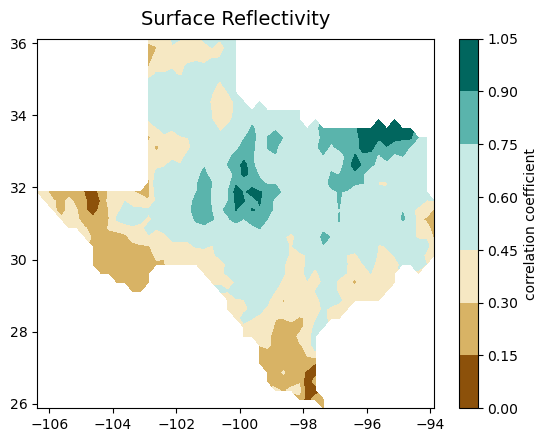

In [68]:
ax = plt.contourf(x_esa,y_esa,np.reshape(RR2,(42,51)),cmap = cmap) 
plt.title(f'Surface Reflectivity', fontsize=14,pad = 10)  
plt.contourf(x_esa,y_esa,np.reshape(RR2,(42,51)),cmap = cmap) # CYGNSS surface reflectivity
plt.colorbar(extend='both',label = "correlation coefficient")

## PRECIPITATION, done to check if there is any relation between the precipitaion and soil moisture

In [1]:
precip = [] # precipitation
lat_pr = [] # latitude
lon_pr = [] # longitude
for files in glob("C:/Users/AJIN RUFUS/Downloads/GLDAS/New Folder/*.nc4", recursive=False):
    data_pr = nc.Dataset(files, "r")
    precip.append(data_pr["Rainf_f_tavg"][:].filled(np.nan))
    
lat_pr = data_pr["lat"][:].filled(np.nan)
lon_pr = data_pr["lon"][:].filled(np.nan)

NameError: name 'glob' is not defined

In [74]:
x_pr, y_pr = np.meshgrid(lon_pr, lat_pr) # to form a grid of latitude and longitude

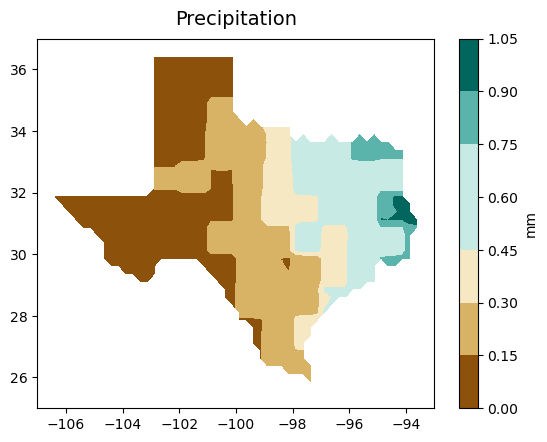

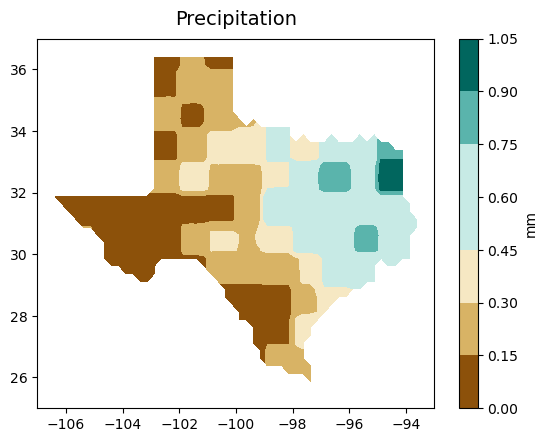

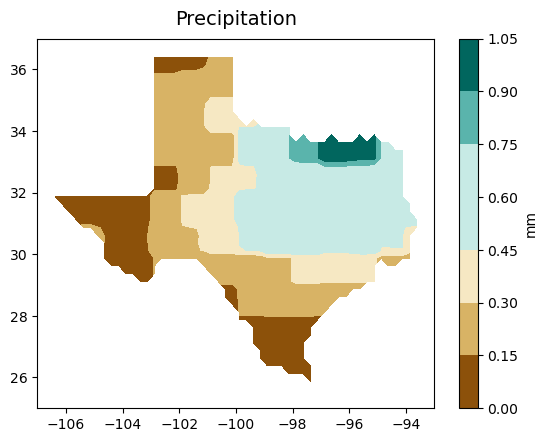

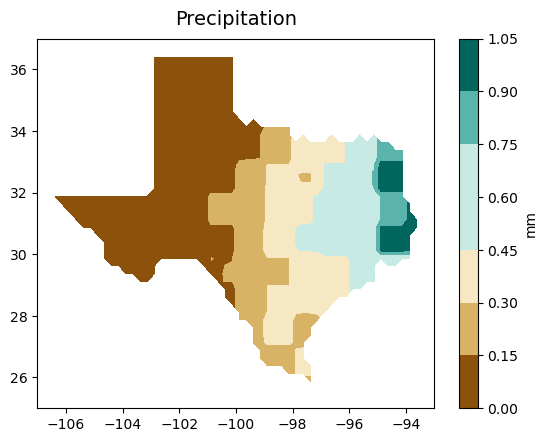

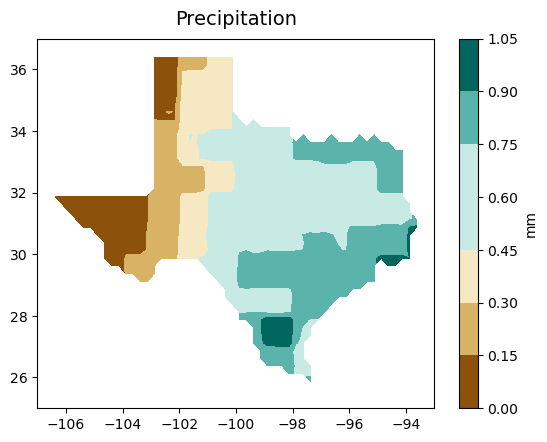

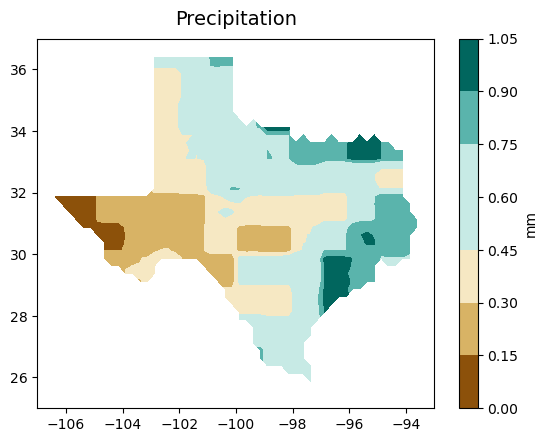

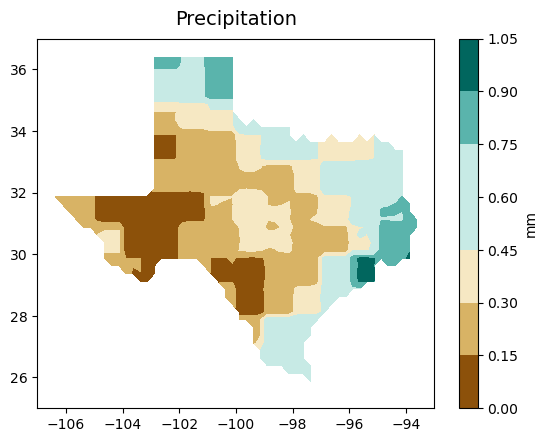

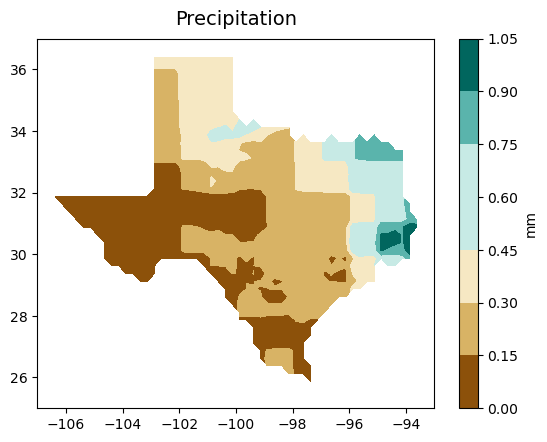

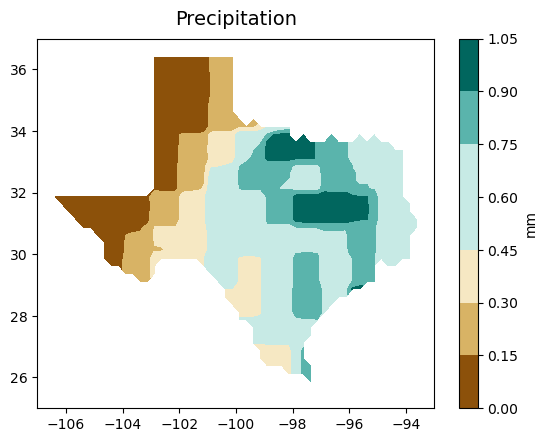

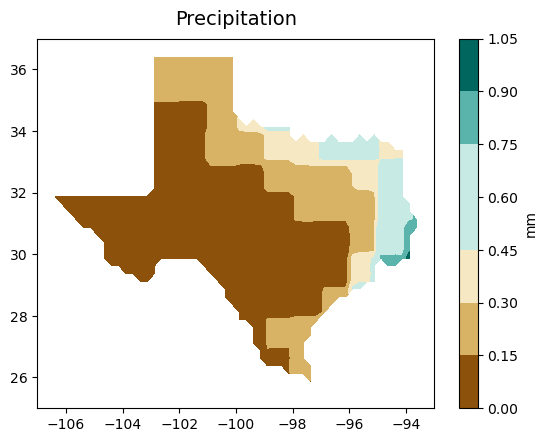

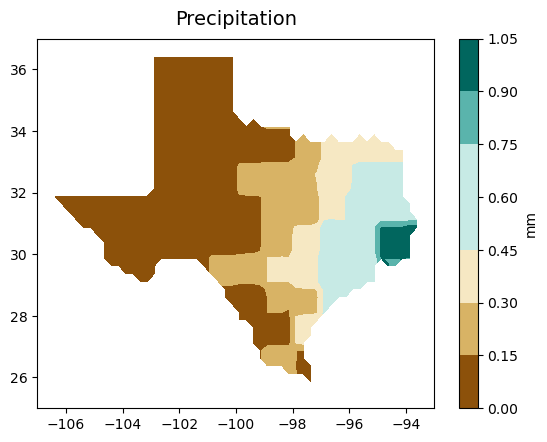

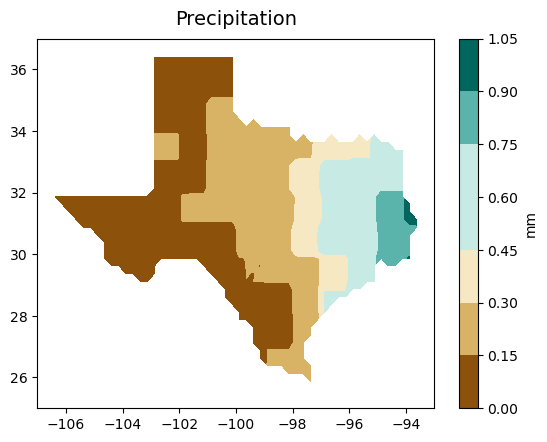

In [81]:
day = [31,29,31,30,31,30,31,31,30,31,30,31] # days in a leap year

pr_val = []

for i in range(len(day)):
    
    abcd1 = precip[i][0]*86400*day[i] # to convert from kg/m/s^2 to mm/month
    
    pr_val.append(np.nanmean(abcd1))
    
    reflect111 = min_max(abcd1)
    ax = plt.contourf(x_pr,y_pr,reflect111,cmap = cmap) 
    plt.title(f'Precipitation', fontsize=14,pad = 10)  
    plt.contourf(x_pr,y_pr,reflect111,cmap = cmap) # plotting the sea surface temperature of each month
    plt.xlim(-107,-93)
    plt.ylim(25,37)
    plt.colorbar(extend='both', label = "mm")
    plt.show()

In [76]:
day = [6,6]
j =0
dd = [182,184]
SS = []
RR = []

for i in range(len(day)):
    abcd2 = np.nanmean(precip[j:j+day[i]][0]*86400*dd[i],axis=0)
    SS.append(abcd2)
    j = j+day[i]

C:\Users\AJIN RUFUS\AppData\Local\Temp\ipykernel_12800\3495379091.py:8: RuntimeWarning: Mean of empty slice
  abcd2 = np.nanmean(precip[j:j+day[i]][0]*86400*dd[i],axis=0)


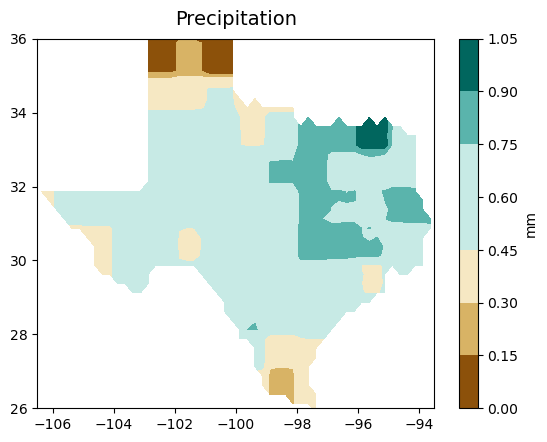

In [77]:
SS1 = SS[0]-SS[1]
SS2 = min_max(SS1)

ax = plt.contourf(x_pr,y_pr,SS2,cmap = cmap) 
plt.title(f'Precipitation', fontsize=14,pad = 10)  
plt.contourf(x_pr,y_pr,SS2,cmap = cmap)
plt.xlim(-106.5,-93.5)
plt.ylim(26,36)
plt.colorbar(extend='both',label = "mm")
plt.show()